In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..')) # Adjust as needed
if project_root not in sys.path:
    sys.path.append(project_root) # add notebook to sys.path

In [2]:
import torch
import torch.nn.functional as F

from utils.data import get_data_tm
from utils.models import LSTMLM
from utils.train import fit_rnn

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [4]:
def print_forward(model, x, state=None):
        print(x.shape)
        x = model.one_hot(x)
        print(x.shape)
        outputs, (h, c) = model.rnn(x, hx=state)
        print(outputs.shape, )
        ret = model.out(outputs)
        print(ret.shape, h.shape, c.shape)

torch.Size([256, 10])
torch.Size([256, 10, 28])
torch.Size([256, 10, 48])
torch.Size([256, 10, 28]) torch.Size([6, 256, 24]) torch.Size([6, 256, 32])


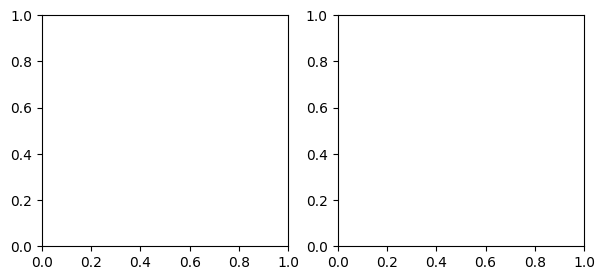

In [5]:
train_dl, val_dl, vocab = get_data_tm(10, 256)
model = LSTMLM(len(vocab), 32, num_layers=3, proj_size=24, bidirectional=True)

for X, Y in train_dl:
    print_forward(model, X)
    break

# expected:
# (256, 10)
# (256, 10, 28)
# only final hidden layer is output from LSTM (no 3)
# (256, 10, 2*24)
# but all hcs at final timestep are kept
# (256, 10, 28), (2*3, 256, 24), (2*3, 256, 32)


In [6]:
def loss_fn(Y_hat, Y):
    Y_hat = Y_hat.reshape(-1, Y_hat.shape[-1])
    Y = Y.reshape(-1,)
    return F.cross_entropy(Y_hat, Y)

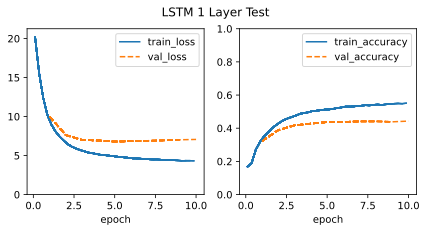

In [7]:
train_dl, val_dl, vocab = get_data_tm(num_steps=32, batch_size=1024, num_train = 2**15, num_val=2**14)
model = LSTMLM(vocab_size=len(vocab), num_hidden=32, num_layers=1)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-1)

model = fit_rnn(train_dl, val_dl, model, opt=optimizer,
                                    loss_fn=loss_fn, num_epochs=10,
                                    id="LSTM 1 Layer Test",
                                    device=device)

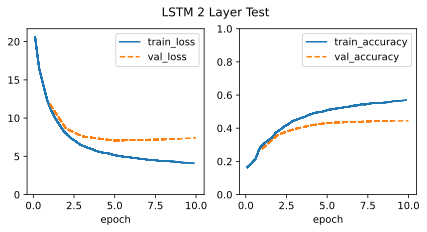

In [8]:
train_dl, val_dl, vocab = get_data_tm(num_steps=32, batch_size=1024, num_train = 2**15, num_val=2**14)
model = LSTMLM(vocab_size=len(vocab), num_hidden=32, num_layers=2)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-1)

model = fit_rnn(train_dl, val_dl, model, opt=optimizer,
                                    loss_fn=loss_fn, num_epochs=10,
                                    id="LSTM 2 Layer Test",
                                    device=device)

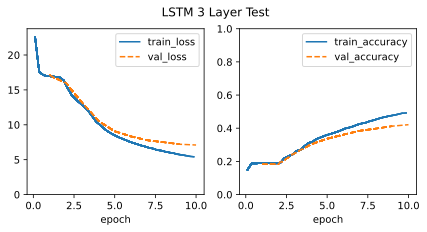

In [10]:
train_dl, val_dl, vocab = get_data_tm(num_steps=32, batch_size=1024, num_train = 2**15, num_val=2**14)
model = LSTMLM(vocab_size=len(vocab), num_hidden=32, num_layers=3)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)

model = fit_rnn(train_dl, val_dl, model, opt=optimizer,
                                    loss_fn=loss_fn, num_epochs=10,
                                    id="LSTM 3 Layer Test",
                                    device=device)